# Tutorial 2.2: Modeling the Refractory Period

## Neuroscience goals:
- understand how a biological feature like the refractory period can be implemented in multiple simplified ways in a model
- become aware of the consequences of different simplifications relative to the behavior of real neurons

## Computational goals
- further practice with nested for loops and use of conditionals to control the path of execution of the code within each for loop
- understand how relevant behaviors can be added into the LIF model using sch computational tools
- learn how to affect the output graph to view spikes, without impacting the simulation

### Tutorial overview
- will simulate the refractory period via three different methods
 - **Forced voltage clamp**
     - clamps/fixes the voltage at its reset value following a spike for the duration of the refractory period
     - absolute refractory period
 - **Refractory conductance**
     - refractory period mimicked by adding a large conductance that produces an outward (hyperpolarizing) potassium current
     - refractory conductance dincreases at the time of each spike and decays between spike times with a short time constant
     - can eliminate reset step, as step increase in conductance following spike causes necessary drop in membrane potential
     - refractory period is not absolute
 - **Raised threshold**
     - voltage threshold required for producing a spike is raised immediately following a spike and decays back to baseline level with a short time constant
     - mean membrane potential increases with firing rate (as in real neurons)
     - refractory period is not absolute
- refractory period limits maximum firing rate of cell
- in each question, will simulate a LIF neuron for 2s using a range of input current (*i_app*) from 100 to 600 pA

---
use the following parameters:
- e_leak = -70mV
- r_membrane = 100 M Ohm
- c_membrane = 0.1 nF


such that membrane potential follows: *c_membrane(dVm/dt) = (e_leak - v_membrane)/r_membrane + i_app*

---
for each question (i.e., all 3 questions on each graph):
- Graph 1: calculate and plot on the same graph the mean firing rate as a function of the input current
- Graph 2: plot the mean membrane potential as a function of the input current
- Graph 3: plot the mean membrane potential as a function of the firing rate
- Explain any trend and any nonmonotonic behavior and the differences between the curves in each figure

---
for each question (use a different graph for each question): 
- separately plot the membrane potential as a function of time for 100ms when Iapp = 220 pA and Iapp = 600 pA (in different colors)
- for each membrane potential, make each spike uptick visible by plotting arise in the membrane potential up to a peak for a single time point
    - (v_peak = 50mV)
- only add the peak to each spike by altering every voltage above v_threshold to be v_peak ***after the simulation through time is complete***, otherwise will disrupt voltage-update rule


### Question 1: Forced voltage clamp
assume spike threshold for the neuron is fixed at v_threshold = -50mV and reset potential is v_reset = -65mV
- if v_membrane > v_threshold, v_membrane = v_reset 
- record spike time
- following a spike, until time is greater than time of last spike + refractory period (t_ref = 2.5ms), fix v_membrane = v_reset instead of following the previous differential equation
    - will need to incorporate an if statement to check whether sufficient time since prior spike has elapsed
    
--- 
#### Notes:
1. will need to initialize the time of last spike to a value less than -t_ref to ensure simulation does not commencein a refractory period
2. to plot spikes in the membrane potential can either plot a single line that increases along the y-axis from v_membrane to v_peak at every spike time (using a for loop) OR after the simulation, change each above-threshold value of v_membrane  to v_peak
3. OR (dirtier method) when resetting v_membrane to v_reset at time of peak, can set the value on the previous time-point to v_peak
    - the previous value is never used again in the simulation, so does not affect the results
    - the shift of the time of the spike by dt will be unnoticable in any figure
    

In [390]:
# Imports

import numpy as np
import matplotlib.pyplot as plt

In [465]:
# Set parameters

e_leak = -70                       # Leak potential, mV
r_membrane = 100e6                 # Resistance, ohm
c_membrane = 0.1e-9                # Conductance, F
v_threshold = -50                  # Spike threshold, mV
v_reset = -65                      # Reset potential, mV
t_ref = 2.5e-3                     # Refractory period, s
v_peak = 50                        # Spike peak, mV
tau_v_threshold = 1e-3             # Refractory time constant, s
tau_g_ref = 2e-3                   # Refreactory conductance time constant
v_threshold_max = 200              # Max spike threshold
e_k = -80                          # Potassium leak potential
delta_g = 2e-7                     # Conductance change step, uS
# delta_g units were giving me a lot of trouble for a while until got it to e-7...



# Initialize time vectors
tmax = 2                           # Time duration, s
dt = 0.0001                        # Time step, s
t = np.arange(0, tmax, dt)

spike_times = np.zeros_like(t)

# Initialize membrane potential vector
v = np.zeros_like(t)
v[0] = e_leak

# Initialize applied current vector, identical to t vector
# Range of input current is 100 to 600 pA

#currents = np.arange(1e-7, 7e-7, 5e-8)
# currents is initialized again later, when needed

i_threshold = (v_threshold - e_leak) / r_membrane
i_0 = i_threshold 
i_app = np.ones_like(t) * i_0

In [392]:
# Define functions
def runsim_clamp(i_app=i_app, sigma=0):
    """
    Run simulation to calculate membrane potential, using forced voltage clamp method to maintain refractory period
    
    Args:
        i_app (ndarray): array of applied currents
        sigma (float): noise value
    Returns:
        v (ndarray): array of membrane potential values
    """
    
    ref_cooldown = 0
    
    # Iterate over time steps
    for i in range(1, t.shape[0]):
        
        if ref_cooldown > 0:                 # If still in refractory period
            v[i] = v_reset                   # Stay at reset value
            ref_cooldown -= dt               # Decrease refractory period
        else:
            noise = np.random.randn() * sigma * np.sqrt(dt)
            dvdt = (e_leak - v[i - 1]) / (r_membrane * c_membrane) + (i_app[i] / c_membrane)
            v[i] = v[i - 1] + dt * dvdt + noise     # Forward euler update

            if v[i] >= v_threshold:                 # If spike
                v[i] = v_reset                      # Reset Vm
                ref_cooldown += t_ref               # Set refractory period
                v[i] = v_peak                       # Add Vm uptick

    return v

def runsim_thresh(i_app=i_app, sigma=0, v_t=v_t):
    """    
    Run simulation to calculate membrane potential, increasing voltage threshold to maintain refractory period
    
    Args:
        i_app (ndarray): array of applied currents
        sigma (float): noise value
    Returns:
        v (ndarray): array of membrane potential values
    """
    
    # Iterate over time steps
    for i in range(1, t.shape[0]):
 
        noise = np.random.randn() * sigma * np.sqrt(dt)
        dvdt = (e_leak - v[i - 1]) / (r_membrane * c_membrane) + (i_app[i] / c_membrane)
        v[i] = v[i - 1] + dt * dvdt + noise     # Forward euler update for membrane potential

        d_thresh_dt = (v_threshold - v_t[i - 1]) / tau_v_threshold
        v_t[i] = v_t[i - 1] + dt * d_thresh_dt  # Forward euler update to decay threshold
        
        if v[i] >= v_t[i]:                      # If spike
            v[i] = v_reset                      # Reset Vm
            v_t[i] = v_threshold_max            # Set spike threshold
            v[i - 1] = v_peak                   # Add Vm uptick
        
    return v



    
def count_spikes(v, v_peak):
    """
    Count number of spikes in membrane potential array
    
    Args:
        v (ndarray): array of membrane potential values
        v_peak (float): threshold value for detecting spikes
    
    Returns:
        counter (int): number of spikes detected
    """
    counter = 0
    # Iterate over membrane potential values
    for i in range(v.shape[0]):
        if v[i] == v_peak:
            counter += 1
            
    return counter
    
def get_rates(currents, model):
    """
    Calculate firing rates for different current values
    
    Returns:
        firing_rates (ndarray): array containing firing rates for each current value
    """
    
    # Initialize firing_rates array
    firing_rates = np.zeros_like(currents)
    
    # Iterate over currents
    for i in range(currents.shape[0]):
        # Reset simulation each time
        v = np.zeros_like(t)
        v[0] = e_leak
        i_0 = currents[i]
        i_app = np.full_like(t, i_0)
        
        # Run simulation
        if model.lower() == 'clamp':
            v = runsim_clamp(i_app=i_app, sigma=0)
        elif model.lower() == 'thresh':
            v = runsim_thresh(i_app=i_app, sigma=0, v_t=v_t)
        elif model.lower() == 'conductance':
            v = runsim_conductance(i_app, 0, v_t)
        else: print('Wrong model! Must be in (clamp, thresh, conductance)')
        
        # Calculate spike rate
        num_spikes = count_spikes(v, v_peak)
        spike_rate = num_spikes / tmax
        firing_rates[i] = spike_rate
    
    return firing_rates

def get_mean_vm(currents, model):
    """
    Calculates mean membrane potential for different current values
    
    Returns:
        mean_vm (ndarray): array containing mean vm for each current value
    """
    
    # Initialize mean_vm array
    mean_vm = np.zeros_like(currents)
    
    # Iterate over currents 
    for i in range(currents.shape[0]):
        # Reset simulation each time
        v = np.zeros_like(t)
        v[0] = e_leak
        i_0 = currents[i]
        i_app = np.full_like(t, i_0)
        
        # Add IF/ELSE for Question Number
        # So that Q1 runs clamp sim, Q2 runs thresh sim, etc. 
        # Run simulation
        if model.lower() == 'clamp':
            v = runsim_clamp(i_app, 0)
        elif model.lower() == 'thresh':
            v = runsim_thresh(i_app, 0, v_t)
        elif model.lower() == 'conductance':
            v = runsim_conductance(i_app, 0, v_t)
        else: print('Wrong model! Must be in (clamp, thresh, conductance)')
        
        # Calculate mean membrane potential
        i_mean = np.mean(v) # Mean vm for this current
        mean_vm[i] = i_mean
        
    return mean_vm

def firing_rate(v, i_app):
    num_spikes = count_spikes(v, v_peak)
    spike_rate = num_spikes / tmax
    return spike_rate


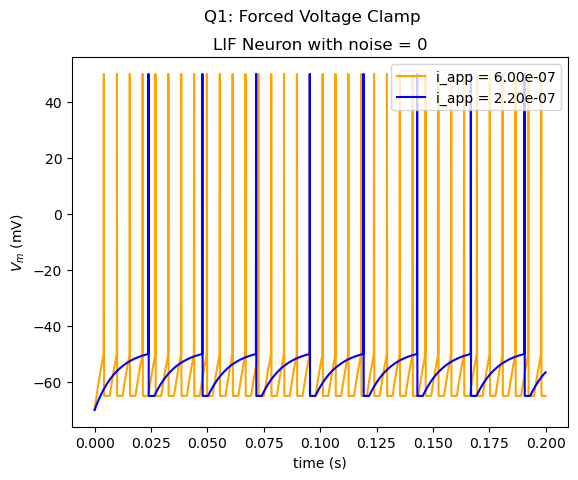

Firing rates:
 2.20e-07: 42.0 Hz
 6.00e-07: 175.5 Hz


In [393]:
# Forced Voltage Clamp

sigma = 0                          # Noise term
t_ref = 2.5e-3                     # Refractory period

# Current thresholds
i_low = i_app * 1.1                # Current threshold (i_threshold)
i_high = i_app * 3                 # i_threshold * 3

# Simulate with high current (600pA)
v_high = runsim_clamp(i_app=i_high, sigma=sigma)
high_rates = firing_rate(v_high, i_high)
plt.plot(t[:2000], v_high[:2000], 'orange', label=f'i_app = {i_high[0]:.2e}')

# Simulate with low current (220pA)
v_low = runsim_clamp(i_app=i_low, sigma=sigma)
low_rates = firing_rate(v_low, i_low)
plt.plot(t[:2000], v_low[:2000], 'blue', label=f'i_app = {i_low[0]:.2e}')

# Plot and display
plt.title(f'LIF Neuron with noise = {sigma}')
plt.suptitle('Q1: Forced Voltage Clamp')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (mV)')
plt.legend(loc="upper right")
plt.show()

# Print firing rates
print(f'Firing rates:\n {i_low[0]:.2e}: {low_rates} Hz\n {i_high[0]:.2e}: {high_rates} Hz')

### Question 2: Threshold increase
make the voltage threshold dynamic so it follows: dV_threshold(t)/dt = (V_threshold^(0) - v_threshold(t))/tau_v_threshold

- with baseline v_threshold^(0) = -50 mV
- initial condition v_threshold(0) = v_threshold^(0)
- refractory time constant tau_v_threshold = 1 ms

at the time of a spike:
- reset v_membrane = v_reset
- increase threshold v_threshold = v_thresh_max = 200 mV

immediately after the spike the dynamical equatios are followed for both v_membrane(t) and v_threshold(t)

#### Notes:
- Create a vector for v_threshold(t) of the same size as v_membrane(t) and update v_threshold(t) in the same for loop as you update v_membrane(t)



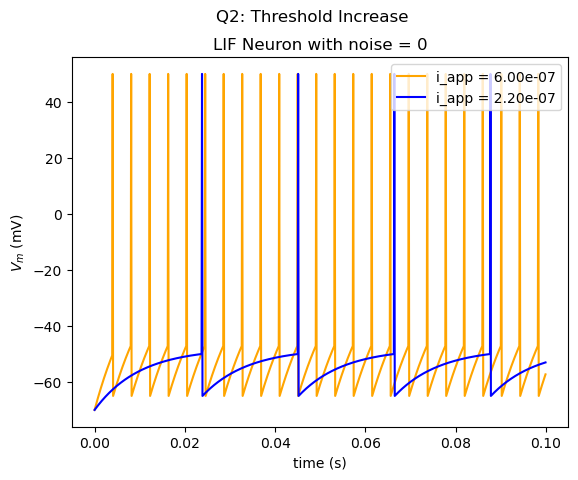

Firing rates:
 2.20e-07: 46.5 Hz
 6.00e-07: 243.5 Hz


In [394]:
# Threshold Increase
# dV_threshold(t)/dt = (V_threshold^(0) - v_threshold(t))/tau_v_threshold

v_t = np.zeros_like(v)                                   # Initialize voltage_threshold vector
v_t[0] = v_threshold

# Current thresholds
i_low = i_app * 1.1                # Current threshold (i_threshold)
i_high = i_app * 3                 # i_threshold * 3

# Simulate with high current (600pA)
v_high = runsim_thresh(i_app=i_high, sigma=sigma, v_t=v_t)
high_rates = firing_rate(v_high, i_high)
plt.plot(t[:1000], v_high[:1000], 'orange', label=f'i_app = {i_high[0]:.2e}')

# Simulate with low current (220pA)
v_low = runsim_thresh(i_app=i_low, sigma=sigma, v_t=v_t)
low_rates = firing_rate(v_low, i_low)
plt.plot(t[:1000], v_low[:1000], 'blue', label=f'i_app = {i_low[0]:.2e}')

# Plot and display
plt.title(f'LIF Neuron with noise = {sigma}')
plt.suptitle('Q2: Threshold Increase')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (mV)')
plt.legend(loc="upper right")
plt.show()


# Print firing rates
print(f'Firing rates:\n {i_low[0]:.2e}: {low_rates} Hz\n {i_high[0]:.2e}: {high_rates} Hz')

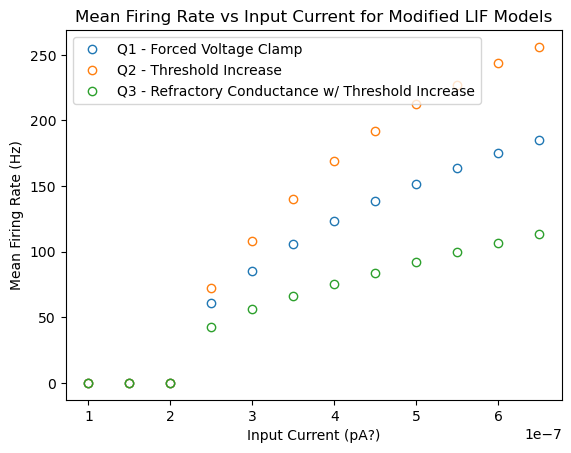

In [468]:
# Graph 1
# Calculate and plot the mean firing rate as a function of the input current

currents = np.arange(1e-7, 7e-7, 5e-8)          # Define range of input currents

for i in range(currents.shape[0]):              # Calculate firing rates for each current value
    clamp_rates = get_rates(currents, model='clamp')           # ndarray 
    thresh_rates = get_rates(currents, model='thresh')
    conductance_rates = get_rates(currents, model='conductance')
    

plt.plot(currents, clamp_rates, 'o', mfc='none', label='Q1 - Forced Voltage Clamp')   # Plot firing rates
plt.plot(currents, thresh_rates, 'o', mfc='none', label='Q2 - Threshold Increase')
plt.plot(currents, conductance_rates, 'o', mfc='none', label='Q3 - Refractory Conductance w/ Threshold Increase')
plt.title('Mean Firing Rate vs Input Current for Modified LIF Models')
plt.legend()
plt.ylabel('Mean Firing Rate (Hz)')
plt.xlabel('Input Current (pA?)')
plt.show()

#### Comments: 
Firing rate is 0 until input current reaches threshold, then an increase in current causes an increase in membrane potential. Q2 - Threshold increase reaches the highest mean firing rate, as the increase in input current is enough to trigger a spike in the neuron with a relatively short interspike interval, compared to Q1 - Forced Voltage Clamp, which has a fixed refractory period that increases the interspike interval at a fixed rate. Q3 - Refractory Conductance w/ Threshold Increase has the lowest mean firing rate, as the outward potassium current mimics a refractory period and requires a higher input current to reach the same mean firing rate as the other two models. 

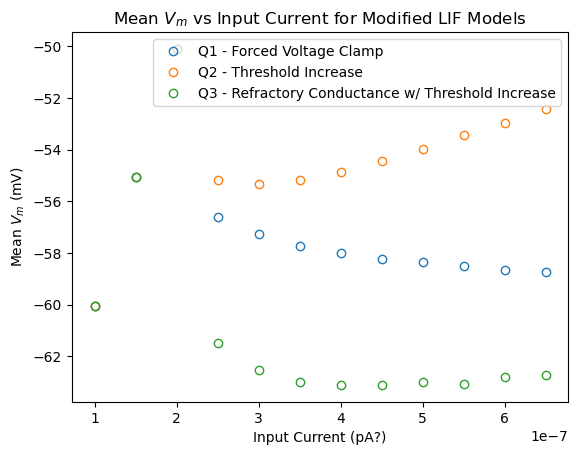

In [469]:
# Graph 2 
# Plot mean membrane potential as a function of the input current

currents = np.arange(1e-7, 7e-7, 5e-8)          # Define range of input currents

for i in range(currents.shape[0]):              # Calculate mean Vm for each current value
    thresh_mean_vms = get_mean_vm(currents, model='thresh')            # ndarray 
    clamp_mean_vms = get_mean_vm(currents, model='clamp')
    conductance_mean_vms = get_mean_vm(currents, model='conductance')

plt.plot(currents, mean_vms, 'o', mfc='none', label='Q1 - Forced Voltage Clamp')   # Plot membrane potentials
plt.plot(currents, thresh_mean_vms, 'o', mfc='none', label='Q2 - Threshold Increase')
plt.plot(currents, conductance_mean_vms, 'o', mfc='none', label='Q3 - Refractory Conductance w/ Threshold Increase')
plt.title('Mean $V_m$ vs Input Current for Modified LIF Models')
plt.legend()
plt.ylabel('Mean $V_m$ (mV)')
plt.xlabel('Input Current (pA?)')
plt.show()

# Peak at current=2 likely right before threshold, where spikes to not occur and Vm therefore never returns to v_reset

#### Comments:
Until the input current reaches threshold, mean membrane potential rises as the neuron spends more time at a higher mean membrane potential beneath the spike threshold. Once the input current reaches threshold, Q1 and Q3 decrease mean membrane potential as a function of input current, because the neuron spends more time at a lower mean membrane potential (i.e., in a refractory period). Q2 increases mean membrane potential as a function of input current, as the neuron is not fixed at the reset value and can increase firing rate as a function of input current, spending more time at higher mean membrane potentials (i.e., in spikes). 

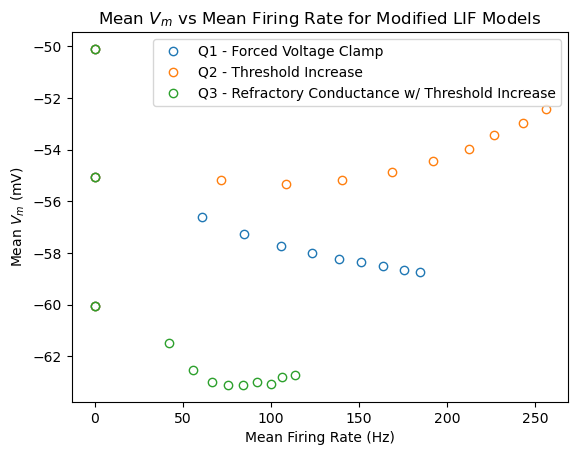

In [467]:
# Graph 3
# Plot the mean membrane potential as a function of the firing rate

currents = np.arange(1e-7, 7e-7, 5e-8)          # Define range of input currents

for i in range(currents.shape[0]):              # Calculate firing rates and mean Vm for each current value
    clamp_mean_vms = get_mean_vm(currents, model='clamp')
    clamp_rate = get_rates(currents, model='clamp')
    thresh_mean_vms = get_mean_vm(currents, model='thresh')            # ndarray 
    thresh_rates = get_rates(currents, model='thresh')                 # ndarray 
    conductance_mean_vms = get_mean_vm(currents, model='conductance')
    conductance_rates = get_rates(currents, model='conductance')
    
    
plt.plot(clamp_rates, clamp_mean_vms, 'o', mfc='none', label='Q1 - Forced Voltage Clamp')
plt.plot(thresh_rates, thresh_mean_vms, 'o', mfc='none', label='Q2 - Threshold Increase')
plt.plot(conductance_rates, conductance_mean_vms, 'o', mfc='none', label='Q3 - Refractory Conductance w/ Threshold Increase')
plt.title('Mean $V_m$ vs Mean Firing Rate for Modified LIF Models')
plt.xlabel('Mean Firing Rate (Hz)')
plt.ylabel('Mean $V_m$ (mV)')
plt.legend()
plt.show()

#### Comments:
Q1 shows a decrease in mean membrane potential as a function of firing rate, as the neuron spends more time in the fixed refractory period, which is independent of firing rate or input current. Q2, however, increases mean membrane potential as a function of firing rate as the refractory period is not fixed, and can increase as a function of input current. The Q2 neuron therefore spends more time at a higher mean membrane potential as the firing rate increases, since it is not forced to remain at the reset value for the duration of the refractory period. The Q3 neuron displays a similar curve to Q2, but at a lower mean membrane potential due to the potassium leak potential = -80mV term used in the model. The firing rate for Q3 reaches it's ceiling at a lower input current. 

### Question 3: Refractory Conductance with Threshold Increase
simulate the LIF dynamics with the additional potassium conductance term as follows: c_membrane(dv_membrane(t)/dt) = (e_leak - v_membrane(t)) / r_membrane + g_ref(t) * (e_k - v_membrane(t)) + i_app

with:
- e_k = -80mv
- dg_ref(t)/dt = - (g_ref(t))/(tau_g_ref)
- at the time of a spike, g_ref = g_ref + delta_g

Initialize the refractory conductance to zero, g_ref(0) = 0
Use:
- tau_g_ref = 0.2ms
- delta_g = 2 microS
- voltage threshold varies in same manner as Q2
    - increasing v_t(t) to v_threshold_max = 200 mV at time of spike
    - decaying to v_t(0) between spikes 

do not change v_membrane(t) at the spike time:
- should see a reduction in v_membrane(t) arise (quickly, but not instantaneously) due to sudden increase in refractory conductance

#### Notes:
- you will need to produce another vector, g_ref(t), of the same size as v_membrane(t) and update it within the same for loop as you update v_membrane(t) and v_threshold(t)

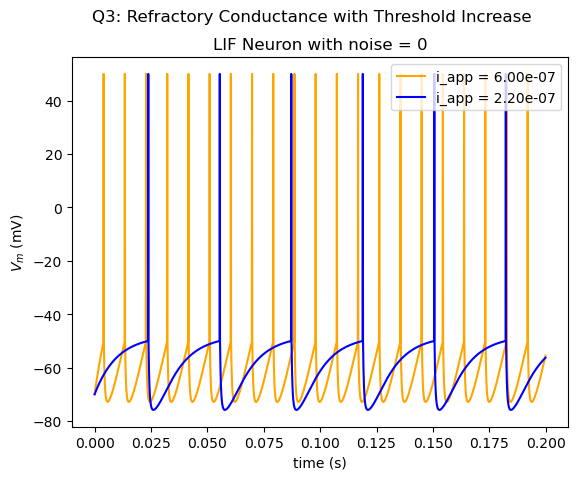

Firing rates:
 2.20e-07: 31.5 Hz
 6.00e-07: 106.5 Hz


In [470]:
# Refractory conductance with threshold increase

def runsim_conductance(i_app=i_app, sigma=0, v_t=v_t):
    """    
    Run simulation to calculate membrane potential, increasing voltage threshold to maintain refractory period and
    adding a potassium conductance term
    
    Args:
        i_app (ndarray): array of applied currents
        sigma (float): noise value
    Returns:
        v (ndarray): array of membrane potential values
    """
    
    # Iterate over time steps
    for i in range(1, t.shape[0]):
 
        noise = np.random.randn() * sigma * np.sqrt(dt)
        dvdt = ((e_leak - v[i - 1]) / (r_membrane * c_membrane)) + ((g_ref[i - 1]*(e_k - v[i - 1]))/c_membrane) + (i_app[i]) / c_membrane
        
        v[i] = v[i - 1] + dt * dvdt + noise         # Forward Euler update for membrane potential

        d_thresh_dt = (v_threshold - v_t[i - 1]) / tau_v_threshold
        v_t[i] = v_t[i - 1] + dt * d_thresh_dt      # Forward Euler update to decay threshold
        
        d_g_ref_dt = -(g_ref[i - 1] / tau_g_ref)
        g_ref[i] = g_ref[i - 1] + dt * d_g_ref_dt    # Forward Eurler update refractory conductance
        
        
        if v[i] >= v_t[i]:                      # If spike
            # v[i] = v_reset                      # Reset Vm
            v_t[i] = v_threshold_max            # Set spike threshold
            g_ref[i] = g_ref[i - 1] + delta_g   # Increase conductance term
            v[i - 1] = v_peak                   # Add Vm uptick
        
    return v

g_ref = np.zeros_like(v)
g_ref[0] = 0

# Current thresholds
i_low = i_app * 1.1
i_high = i_app * 3

# Simulate with high current (600pA)
v_high = runsim_conductance(i_high, 0, v_t)
high_rates = firing_rate(v_high, i_high)
plt.plot(t[:2000], v_high[:2000], 'orange', label=f'i_app = {i_high[0]:.2e}')

# Simulate with low current (220pA)
v_low = runsim_conductance(i_low, 0, v_t)
low_rates = firing_rate(v_low, i_low)
plt.plot(t[:2000], v_low[:2000], 'blue', label=f'i_app = {i_low[0]:.2e}')

# Plot and display
plt.title(f'LIF Neuron with noise = {sigma}')
plt.suptitle('Q3: Refractory Conductance with Threshold Increase')
plt.xlabel('time (s)')
plt.ylabel('$V_m$ (mV)')
plt.legend(loc='upper right')
plt.show()

# Print firing rates
print(f'Firing rates:\n {i_low[0]:.2e}: {low_rates} Hz\n {i_high[0]:.2e}: {high_rates} Hz')